# Imports

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from fa2 import ForceAtlas2
import numpy as np
import csv
import networkx as nx
import os
#couchsurfing API is external API locally saved also available in our github: https://github.com/eikekutz/SocialGraphFinalProject
from couchsurfing import Api
from random import randint
from time import sleep
from geopy import geocoders
import unidecode
import conda
import pickle
import collections

#Necessary Settings for the conda package to work with the Basemap if it gives errors
# - if you are missing Basemap package, just please execute: conda install -c conda-forge basemap

# - if it still doesn't work try to uncomment lines below:

#conda_file_dir = conda.__file__
#conda_dir = conda_file_dir.split('lib')[0]
#proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
#os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap


 * **0\. Data Extraction**
    * 0.1\. Couchsurfing API Data Gathering
        * 0.1.1\. Get Hosts Data
        * 0.1.2\. Get Reviews and Reviewers Data
    * 0.2\. Data Merging
    * 0.3\. Adding Geo Location of Users
    * 0.4\. Cleaning Data
    
* 1\. Project's objective (**fix list problem**)
    * 1.1\. What do we want to answer in this project
    * 1.2\. Datasets limitations
    
* **2\. Preliminary Data Analysis**
    * 2.1\. User
        * 2.1.1\. User Analysis
        * 2.1.2\. User Statistics
        * 2.1.3\. User Graphs
    * 2.2\. City
        * 2.2.1\. City Clustering
        * 2.2.2\. City Analysis
        * 2.2.3\. City Statistics
        * 2.2.4\. City Graphs

* **3\. Network Construction**
    * 3.1\.User 
        * 3.1.1\. Initial Analysis
    * 3.2\.City 
        * 3.2.1\. Initial Analysis

* **4\. Basic Network Analysis**
    * 4.1\. Degree Distribution
        * 4.1.1 Network degree (in, out, total) distribution
        * 4.1.2 Nodes' degree (in and out) comparison
    * 4.2\. Power-laws and Friendship Paradox
    * 4.3\. Centrality
        * 4.3.1 Betweenness Centrality
        * 4.3.2 Eigenvector Centrality
    * 4.4\. Assortativity
    * 4.5\. Modularity and Communities
    * 4.6\. Network Visualizations and Statistics

* **5\. Analysis of Review data**
    * 5.1\. Wordclouds
    * 5.2\. Happiness Averages
        * 5.2.1\. Users
        * 5.2.2\. Cities

* **6\. Analysis of specific Users**
    * 6.1\. Get Profile Data
    * 6.2\. Combined sentiment
        * 6.1.1\. Overall/Host/Surfer -Review
        * 6.1.1\. Image Sentiment
        * 6.1.1\. Profile description Sentiment ( 
    * 6.2\. Best/Worst User
        * 6.2.1\. Best/Worst Couchsurfer
        * 6.2.1\. Best Host

* **7\. Discussion**

# 0.Data Extraction#

In [2]:
def getHostFromCity(city,latitude,longitude):
    '''
    getting all the host data within a circle with a radius of 25km 
    max 20 pages with each 100 users
    '''
    print("Getting results for ",city,latitude,longitude)
    for p in range(1,20):
        print(p)
        ##hosts = api.get_hosts(city,25,100,p)
        ##hosts = api.get_hosts(city,25,100,None,'best_match',"yes,maybe",None,p,last_login)
        hosts = api.get_hosts_latlong(latitude,longitude,p,100,25,4)
        writeCityResults2File(hosts,city,p)
        sleep(randint(2,5))

In [3]:
def writeCityResults2File(results,cityString,page):
    '''
    writing hosts to csv file 100 users for each file
    '''
    with open('data/Top50/hosts/'+cityString+str(page)+'.csv','w',newline="") as f:
        writer = csv.writer(f,delimiter = ',')
        # Write CSV Header, If you dont need that, remove this line
        writer.writerow(["id",
                "publicName",
                "avatarUrl",
                "isVerified",
                "status",
                "lastLogin",
                "aboutText",
                "responseRate",
                "responseTimeText",
                'responseRateText',
                "totalReferencesCount",
                "profileLink",
                "friendsCount",
                "languages",
                "city"])

        for host in results['results']:
            writer.writerow([host["id"],
                    host["publicName"],
                    host["avatarUrl"],
                    host["isVerified"],
                    host["status"],
                    host["lastLogin"],
                    host["aboutText"],
                    host["responseRate"],
                    host["responseTimeText"],
                    host["responseRateText"],
                    host["totalReferencesCount"],
                    host["profileLink"],
                    host["friendsCount"],
                    host["languages"],
                    cityString])

In [98]:
#import nodes to get id from nodes/hosts
def importHosts(index):
    '''
    Import merged hosts to get id, which is used to download the reviews for each user
    '''
    hosts = pd.DataFrame() #creates a new dataframe that's empty
    city = cities.loc[index]
    for p in range(1,15):
        if (os.path.exists('data/Top50/hosts/'+city['name']+str(p)+'.csv')):
            df = pd.read_csv('data/Top50/hosts/'+city['name']+str(p)+'.csv')
            hosts = pd.concat([hosts,df]).reset_index(drop=True)
    return hosts

In [3]:
def createRevCityList(city): 
    '''
    Create a csv file for the given city to store reviews of the city
    '''
    with open('data/Top50/reviews/'+city+'Rev.csv','w',newline="") as f:
            writer = csv.writer(f,delimiter = ',')
            writer.writerow(["id",
                    "text",
                    "createdDate",
                    "experience",
                    "relationshipType",
                    "isPostTrip",
                    "to",
                    "from",
                    "fromPublicName",
                    "fromPublicAddressId",
                    "fromPublicAddressDescription",
                    "fromAvatarUrl",
                    "fromStatus",
                    "fromIsVerified",
                    "fromIsDeleted",
                    "fromBlockedBy",
                    "inverseReference",
                    "response"])

In [4]:
def appendReview(file,city):
    '''
    Append Reviews of the user on the specific city reviews csv file
    '''
    with open('data/Top50/reviews/'+city+'Rev.csv','a',newline="") as f:
        writer = csv.writer(f,delimiter = ',')
        for host in file['results']:
            writer.writerow([host["id"],
                host["text"],
                host["createdDate"],
                host["experience"],
                host["relationshipType"],
                host["isPostTrip"],
                host["to"]['id'],
                host["from"]['id'],
                host["from"]["publicName"],
                host["from"]["publicAddress"]["id"],
                host["from"]["publicAddress"]["description"],
                host["from"]["avatarUrl"],
                host["from"]["status"],
                host["from"]["isVerified"],
                host["from"]["isDeleted"],
                host["from"]["blockedBy"],
                host["inverseReference"],
                host["response"]])

In [5]:
def getReferenceForCity(index):
    '''
    Get the reviews for every hosts for a given city based on the downloaded host dataset
    '''
    hosts= importHosts(index=index)
    city = cities.loc[index]
    print("Getting results for ",city['name'])
    createRevCityList(city['name'])
    for idx,host in hosts.iterrows():
        test=api.get_references(uid=host['id'],type='host')
        appendReview(test,city['name'])
        test=api.get_references(uid=host['id'],type='surf')
        appendReview(test,city['name'])     

## 0.1. Couchsurfing API Data Gathering

In [ ]:
#Get all the hosts from a city , iterating over the city list
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    getHostFromCity(city['name'],city['lat'],city['lng'])
    sleep(randint(10,20))

In [ ]:
#Getting the references for all the hosts
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    if idx>10:
        getReferenceForCity(idx)
        sleep(randint(5,10))

## 0.2. Data Merging



In [99]:
#Merging host's data
cities = pd.read_csv('data/Top50/top50cities.csv',delimiter=',')
hosts = pd.DataFrame() #creates a new dataframe that's empty
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    for p in range(1,14):
        if (os.path.exists('data/Top50/hosts/'+city['name']+str(p)+'.csv')):
            df = pd.read_csv('data/Top50/hosts/'+city['name']+str(p)+'.csv',index_col=False,dtype={'id': np.int64})
            hosts = pd.concat([hosts,df]).reset_index(drop=True)
hosts=hosts.drop_duplicates()

In [100]:
print(len(hosts))

10582


In [101]:
#merging review data
rev = pd.DataFrame() #creates a new dataframe that's empty
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    if os.path.exists('data/Top50/reviews/'+city['name']+'Rev.csv'):
        df = pd.read_csv('data/Top50/reviews/'+city['name']+'Rev.csv',index_col=False)
        rev = pd.concat([rev,df]).reset_index(drop=True)
rev=rev.drop_duplicates()

In [102]:
#adding sentiment analysis of the reviews
# load data from pickle
sentiment_per_review_dict = pickle.load( open( 'data/Top50/reviews/Pickles/SentimentPerReview_Dict.pickle', "rb" ) )
# map values from dictionary into dataframe by rev_id
rev['sentimentValue'] = rev['id'].map(sentiment_per_review_dict)

print(list(sentiment_per_review_dict.values()).count(None),' of ',len(list(sentiment_per_review_dict)), 'has been ommited due to the lack of sentiment')
                                    

9021  of  96085 has been ommited due to the lack of sentiment


In [105]:
# create multigraph 
G_withSentValue = nx.MultiDiGraph()

# filter out reviews from these that don't have sentiment value
couchserfing_reviews = rev.loc[ rev['sentimentValue'].notnull()]

#append edges to the multigraph
couchserfing_reviews=couchserfing_reviews.rename(columns = {'sentimentValue':'weight'})
G_withSentValue = nx.from_pandas_dataframe(couchserfing_reviews, 'from', 'to', edge_attr=['weight','relationshipType'], create_using=nx.MultiDiGraph())
couchserfing_reviews=couchserfing_reviews.rename(columns = {'weight':'sentimentValue'})

# todo: filter nodes without connection abour 10000
G_withSentValue.add_nodes_from([(rows['id'],{'city':rows['city']}) for idx,rows in hosts.iterrows()])

print(len(G_withSentValue.nodes))
print(len(G_withSentValue.edges))
#test
#print(len(G_withSentValue.edges))
#(len(couchserfing_reviews))

87427
87064


In [7]:
#creatdiGraph to see how many edges will be overriten calculation of re-visites
G = nx.DiGraph()

G.add_nodes_from([(rows['id'],{'city':rows['city']}) for idx,rows in hosts.iterrows()])

G = nx.from_pandas_dataframe(couchserfing_reviews, 'from', 'to')


In [109]:
print(G_withSentValue[2001999679][2009059021])
print(G_withSentValue[2007724821][2009059021])
rev.head(2)

{0: {'weight': 6.768571428571428, 'relationshipType': 'host'}}
{0: {'weight': 6.403125000000003, 'relationshipType': 'surf'}}


id                                               text  \
0  27077307  Amazing chef and humble human being. Willing t...   
1  27152728  Amazing boy with amazing family . He met me up...   

            createdDate experience relationshipType isPostTrip          to  \
0  2018-10-17T22:09:22Z   positive             host       True  2009059021   
1  2018-10-28T19:16:31Z   positive             surf       True  2009059021   

         from     fromPublicName  fromPublicAddressId  \
0  2001999679      Dhanush Anand          109610804.0   
1  2007724821  Bakhar Sardzhaeva          271153483.0   

    fromPublicAddressDescription  \
0  Setiabudi, Jakarta, Indonesia   
1                          Dubai   

                                       fromAvatarUrl fromStatus  \
0  https://s3.amazonaws.com/ht-images.couchsurfin...        yes   
1  https://s3.amazonaws.com/ht-images.couchsurfin...         no   

  fromIsVerified fromIsDeleted  fromBlockedBy inverseReference response  \
0           True         False            NaN              NaN      NaN   
1          False         False            NaN              NaN      NaN   

  sentimentValue  
0        6.76857  
1        6.40313

## 0.3. Adding Geo Location of Users



In [ ]:
cities_not_found = []
def getCityCoords(name):
    gn = geocoders.GeoNames(username='kacper')
    try:
        loc = gn.geocode(name, timeout=10)
        if loc is None:
            try: 
                loc =gn.geocode(name.split(',')[0],timeout=10)
                if loc is None:
                    raise TypeError
            except Exception as inst:
                print('This city was not found:',name)
                return None
    except Exception as inst:
        print('This city was not found:',name)
        cities_not_found.append(name)
        return None
    #print(len(loc))
   # print(loc[0].raw)
    return loc

In [ ]:
#source: https://www.maxmind.com/en/free-world-cities-database
worldCities = pd.read_csv('../worldcitiespop.txt',encoding = "ISO-8859-1")
#source: https://datahub.io/core/country-list#resource-data
cc= pd.read_csv('data/country_map.txt')

In [15]:
#Example how the data look like:
print('Number of entries worldCitiespop.txt: ',len(worldCities))
worldCities.head(3)

Number of entries worldCitiespop.txt:  3173958


Country        City  AccentCity Region  Population   Latitude  Longitude
0      ad       aixas       Aixàs      6         NaN  42.483333   1.466667
1      ad  aixirivali  Aixirivali      6         NaN  42.466667   1.500000
2      ad  aixirivall  Aixirivall      6         NaN  42.466667   1.500000

In [ ]:

uniqueCities=rev.fromPublicAddressDescription.unique()
uniqueCities = uniqueCities.tolist()

In this Part we map a geographical position to every review.
With this information we know the reviewer geographical position.
Due to the high number of reviewer's unique locations and the geopy API's limitation of 5000 requests a day we used the worldcitiespop.txt.
If an entry couldn't be found in this list we used the geopy API to supplement the missing entries.
If a review's location couldn't be found it will be droppend afterwards.
The nummber of not found location is 815 out of 96085 with is a 0.848% of the reviews data.

In [4]:
exList=["nan"]
for city in unique:
    if all([c[1]=='NaN'for c in rev.loc[rev.fromPublicAddressDescription==city]['lat'].iteritems()]):
        if str(city).lower() not in exList:
            #Search for entry in the worldcities list and map with country code (cc) if necessary
            loc = worldCities.loc[worldCities.City==city.split(',')[0].lower().strip()]
            if len(loc.index)>1:
                try:
                    countryCode = cc.loc[cc.Name==city.split(',')[-1].strip().lower().title()]['Code'].values[0]
                    loc =loc.loc[loc.Country==countryCode.lower()].head(1)
                except:
                    loc=loc.head(1)
            if len(loc.head(1).index)==0:
                c=test=unidecode.unidecode(city)
                loc = worldCities.loc[worldCities.City==c.split(',')[0].lower().strip()].head(1)
                if len(loc.index)>1:
                    try:
                        countryCode = cc.loc[cc.Name==c.split(',')[-1].strip().lower().title()]['Code'].values[0]
                        loc =loc.loc[loc.Country==countryCode.lower()].head(1)
                    except:
                        loc=loc.head(1)  

            if len(loc.head(1).index)==1:
                l=rev.loc[rev.fromPublicAddressDescription==city].index.tolist()
                for i in l:
                    rev.set_value(i,'lat',loc.Latitude.values[0])
                    rev.set_value(i,'lng',loc.Longitude.values[0])
                    rev.set_value(i,'city',loc.City.values[0])
                    rev.set_value(i,'country',loc.Country.values[0])

            else:
            #is the entry not found in the worldcities use the API to download the geoposition    
                print('try api for :',city)
                res = getCityCoords(city)
                try:
                    l=rev.loc[rev.fromPublicAddressDescription==city].index.tolist()
                    for i in l:
                        rev.set_value(i,'lat',res.latitude)
                        rev.set_value(i,'lng',res.longitude)
                        rev.set_value(i,'city',res.address.split(' ')[0].lower())
                        rev.set_value(i,'country',res.address.split(' ')[-1].lower())
                except:
                    print('Could not found ',city)
export_csv = rev.to_csv ('data/reviews_total_geo_x.csv', index = None, header=True)

NameError: name 'unique' is not defined

## 0.4. Cleaning Data



In [110]:
# erase nodes with no edges: there is no such nodes as firstly we added hosts that have edges for sure and then we added rev wchich creates just necessary nodes
print(len(G_withSentValue.nodes))
remove = []
for key, value in G_withSentValue.degree():
    if value < 1:
        remove.append(key)
G_withSentValue.remove_nodes_from(remove)
len(G_withSentValue.nodes)

87427


83052


## 3. Network Construction

In [12]:
d=G_withSentValue.degree()

forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=0.5,

                          # Performance
                          jitterTolerance=0.2,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.5,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=6.0,
                          strongGravityMode=False,
                          gravity=0,

                          # Log
                          verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(G_withSentValue, pos=None, iterations=150)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [31:00<00:00, 10.08s/it]


BarnesHut Approximation  took  76.13  seconds
Repulsion forces  took  1776.73  seconds
Gravitational forces  took  0.99  seconds
Attraction forces  took  0.41  seconds
AdjustSpeedAndApplyForces step  took  4.45  seconds


In [111]:
# create empty list for node colors
def random_color():
    return np.random.choice(range(256), size=3)/256# for each node in the graph
import matplotlib
def getColorfromCmap(val):
    cmap = matplotlib.cm.get_cmap('tab20')
    return cmap(val)


cmap = matplotlib.cm.get_cmap('Spectral')
cmap2 = matplotlib.cm.get_cmap('tab20')

legend_city=[city['name'] for idx,city in cities.iterrows()]
legend_city.append('outside')
legend_col=[getColorfromCmap(idx/(len(legend_city)-1)) for idx,x in enumerate(legend_city)]

node_to_color_dict = dict()
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        for idx,city in cities.iterrows():
            if node[1]['city'] == city['name'] :
                node_to_color_dict[node[0]] = legend_col[idx]
    else:
        node_to_color_dict[node[0]] = legend_col[20]



In [112]:
node_to_city_dict = dict()
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        if node[0] not in node_to_city_dict:
            node_to_city_dict[node[0]] = node[1]['city']
    else:
        node_to_city_dict[node[0]] = 'outside'
        


In [113]:
citi_to_color_dict = dict()
for idx, city in enumerate(legend_city,start=0):
    citi_to_color_dict[city] = legend_col[idx]
citi_to_color_dict

{'Barcelona': (0.7372549019607844,
  0.7411764705882353,
  0.13333333333333333,
  1.0),
 'Belgrade': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058, 1.0),
 'Berlin': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 'Bucharest': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 'Budapest': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0),
 'Hamburg': (0.5490196078431373,
  0.33725490196078434,
  0.29411764705882354,
  1.0),
 'Kharkiv': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0),
 'Kyiv': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 'London': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 'Madrid': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 'Milan': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0),
 'Minsk': (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0),
 'Moscow': (0.12156862745098039, 0.4666666666666667, 0

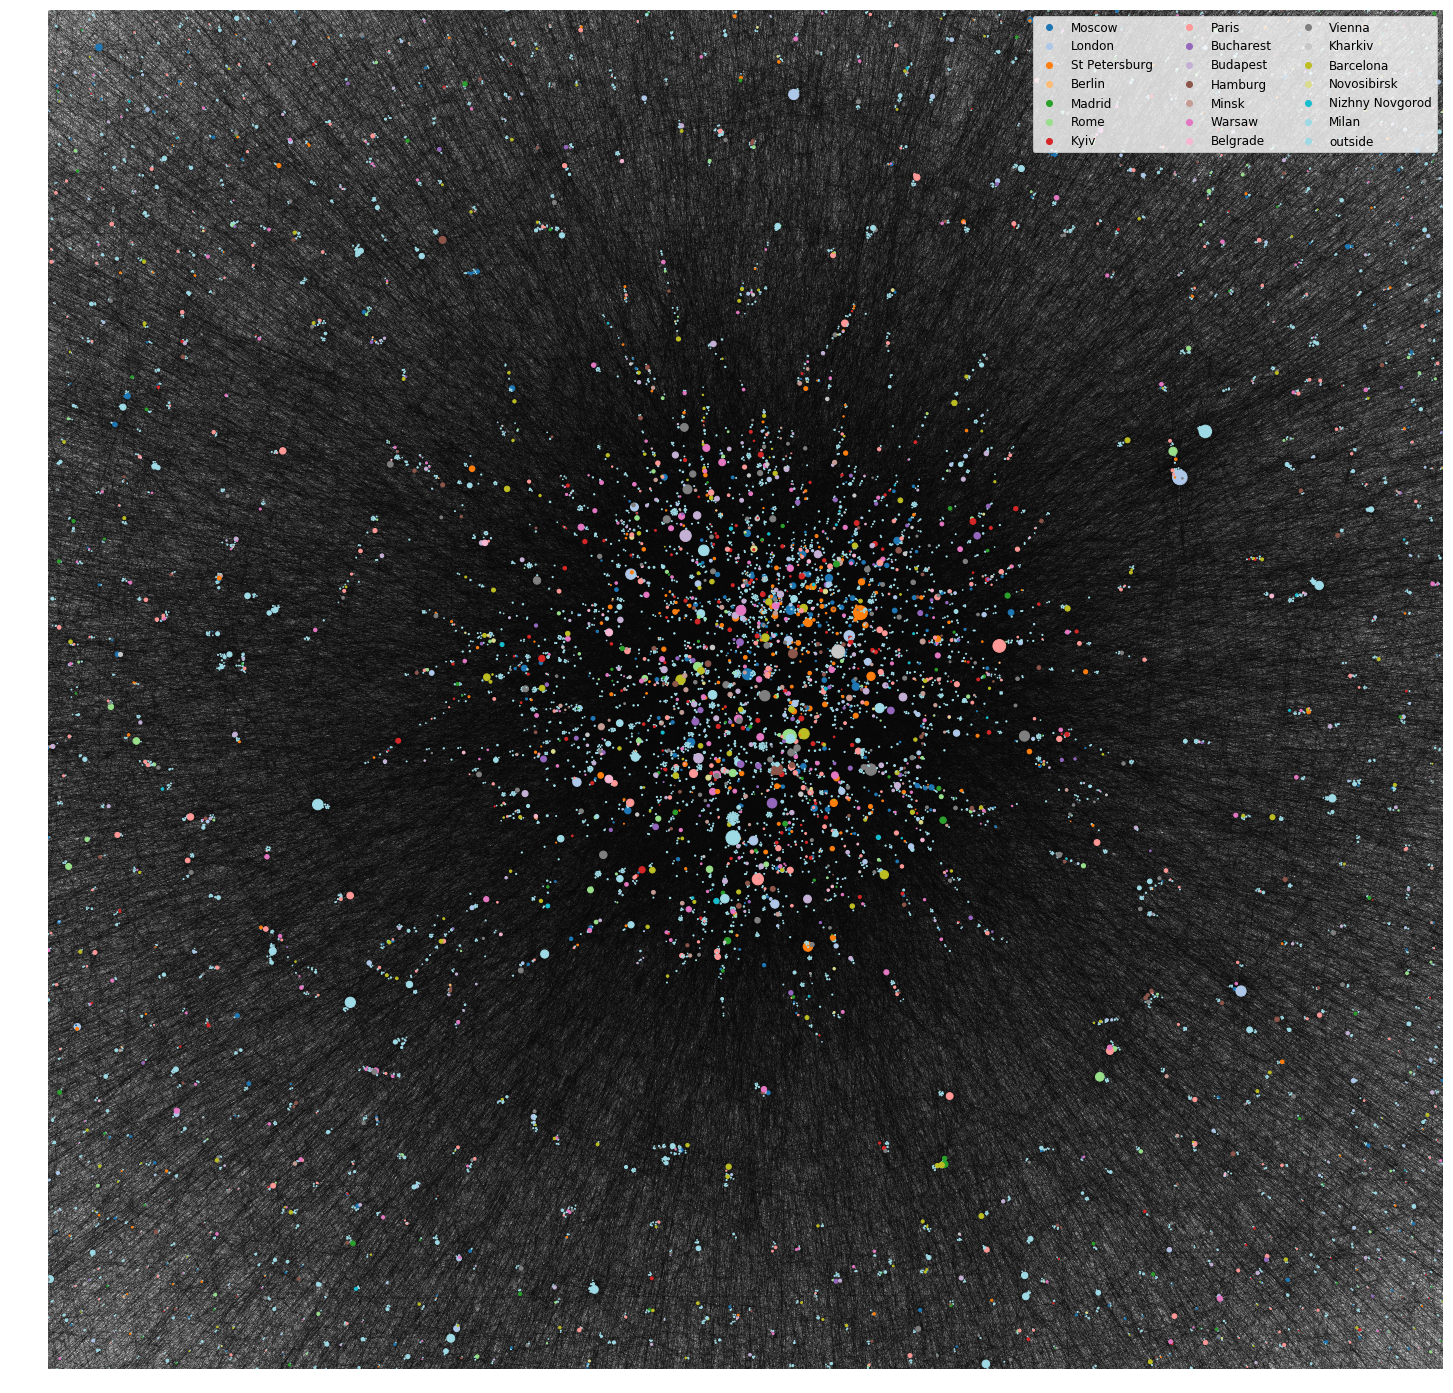

In [27]:
# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(1,1,1)
for label in legend_city  :
    ax.scatter([0],[0],color=citi_to_color_dict[label],label=label)

# Just fixed the color map
nx.draw_networkx(G_withSentValue,pos=positions,with_labels = False, width=0.02,node_size=[v[1] * 0.5 for v in d]
                 ,node_color=[v for k,v in node_to_color_dict.items()],ax=ax, labels=None, label=None)

plt.xlim(-5000,5000)
plt.ylim(-5000,5000)
# Setting it to how it was looking before.                                                                                                              
plt.axis('off')

plt.legend(
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)


plt.show()


In [17]:

# to try it out over night ;)



# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(1,1,1)
for label in legend_city  :
    ax.scatter([0],[0],color=citi_to_color_dict[label],label=label)

# Just fixed the color map
nx.draw_networkx(G_withSentValue,with_labels = False, width=0.02,node_size=[v[1] * 0.4 for v in d]
                 ,node_color=[v for k,v in node_to_color_dict.items()],ax=ax, labels=None, label=None)

plt.xlim(-3000,3000)
plt.ylim(-3000,3000)
# Setting it to how it was looking before.                                                                                                              
plt.axis('off')

plt.legend(
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)
plt.show()

SyntaxError: invalid syntax (<ipython-input-17-2b90fa2a71d8>, line 15)

### 3.1.User

#### 3.1.1. Initial Analysis

+ from where are the users? (Eike)
+ We have 10582 hosts that the based our analysis on
+ We have 96085 reviews extracted for that hosts.

In [114]:
# count how many nodes we have per each city and these one with empty feature of city if any:
# total number of nodes: 94831
nodes_city_counter = dict()

nodes_city_counter['outside'] = 1
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        if node[1]['city'] in nodes_city_counter:
            nodes_city_counter[node[1]['city']] += 1
        else:
            nodes_city_counter[node[1]['city']] = 1
    else:
        nodes_city_counter['outside'] +=1
nodes_city_counter

{'Barcelona': 393,
 'Belgrade': 61,
 'Berlin': 118,
 'Bucharest': 120,
 'Budapest': 315,
 'Hamburg': 290,
 'Kharkiv': 68,
 'Kyiv': 364,
 'London': 497,
 'Madrid': 234,
 'Milan': 352,
 'Minsk': 149,
 'Moscow': 710,
 'Nizhny Novgorod': 56,
 'Novosibirsk': 54,
 'Paris': 871,
 'Rome': 251,
 'St Petersburg': 451,
 'Vienna': 387,
 'Warsaw': 465,
 'outside': 76847}

#### 3.1.2. Alternative Construction

+ What are the nodes and reviews in the goe representation of the network (Eike)


## 4. Basic Network Analysis

In [115]:
# validation of the data:
print('Number of all reviews: ',len(rev) )
userRevWithSentVal = rev.loc[ rev['sentimentValue'].notnull()]
print('Number of all reviews with sentiment: ',len(userRevWithSentVal))
print('Edges without sentiment: ', len(rev) - len(userRevWithSentVal) )
print('How many edges are unique ( from these with sentiment) ',len(G.edges),' / 87064  not unique ( no of revisits ): ===>', len(userRevWithSentVal) -  len(G.edges) )
print('Number of all reviews we are using for analysis: ',len(G_withSentValue.edges))

Number of all reviews:  96085
Number of all reviews with sentiment:  87064
Edges without sentiment:  9021
How many edges are unique ( from these with sentiment)  94874  / 87064  not unique ( no of revisits ): ===> -7810
Number of all reviews we are using for analysis:  87064


### 4.1. Degree Distribution:

#### 4.1.1 Network degree (in, out, total) distribution:

In [116]:
# calculating degree distribution:

# in general ( in and out )
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

# in
in_degree_sequence = sorted([d for n, d in G_withSentValue.in_degree()], reverse=True)  # degree sequence
in_degreeCount = collections.Counter(in_degree_sequence)
in_deg, in_cnt = zip(*in_degreeCount.items())

# out
out_degree_sequence = sorted([d for n, d in G_withSentValue.out_degree()], reverse=True)  # degree sequence
out_degreeCount = collections.Counter(out_degree_sequence)
out_deg, out_cnt = zip(*out_degreeCount.items())

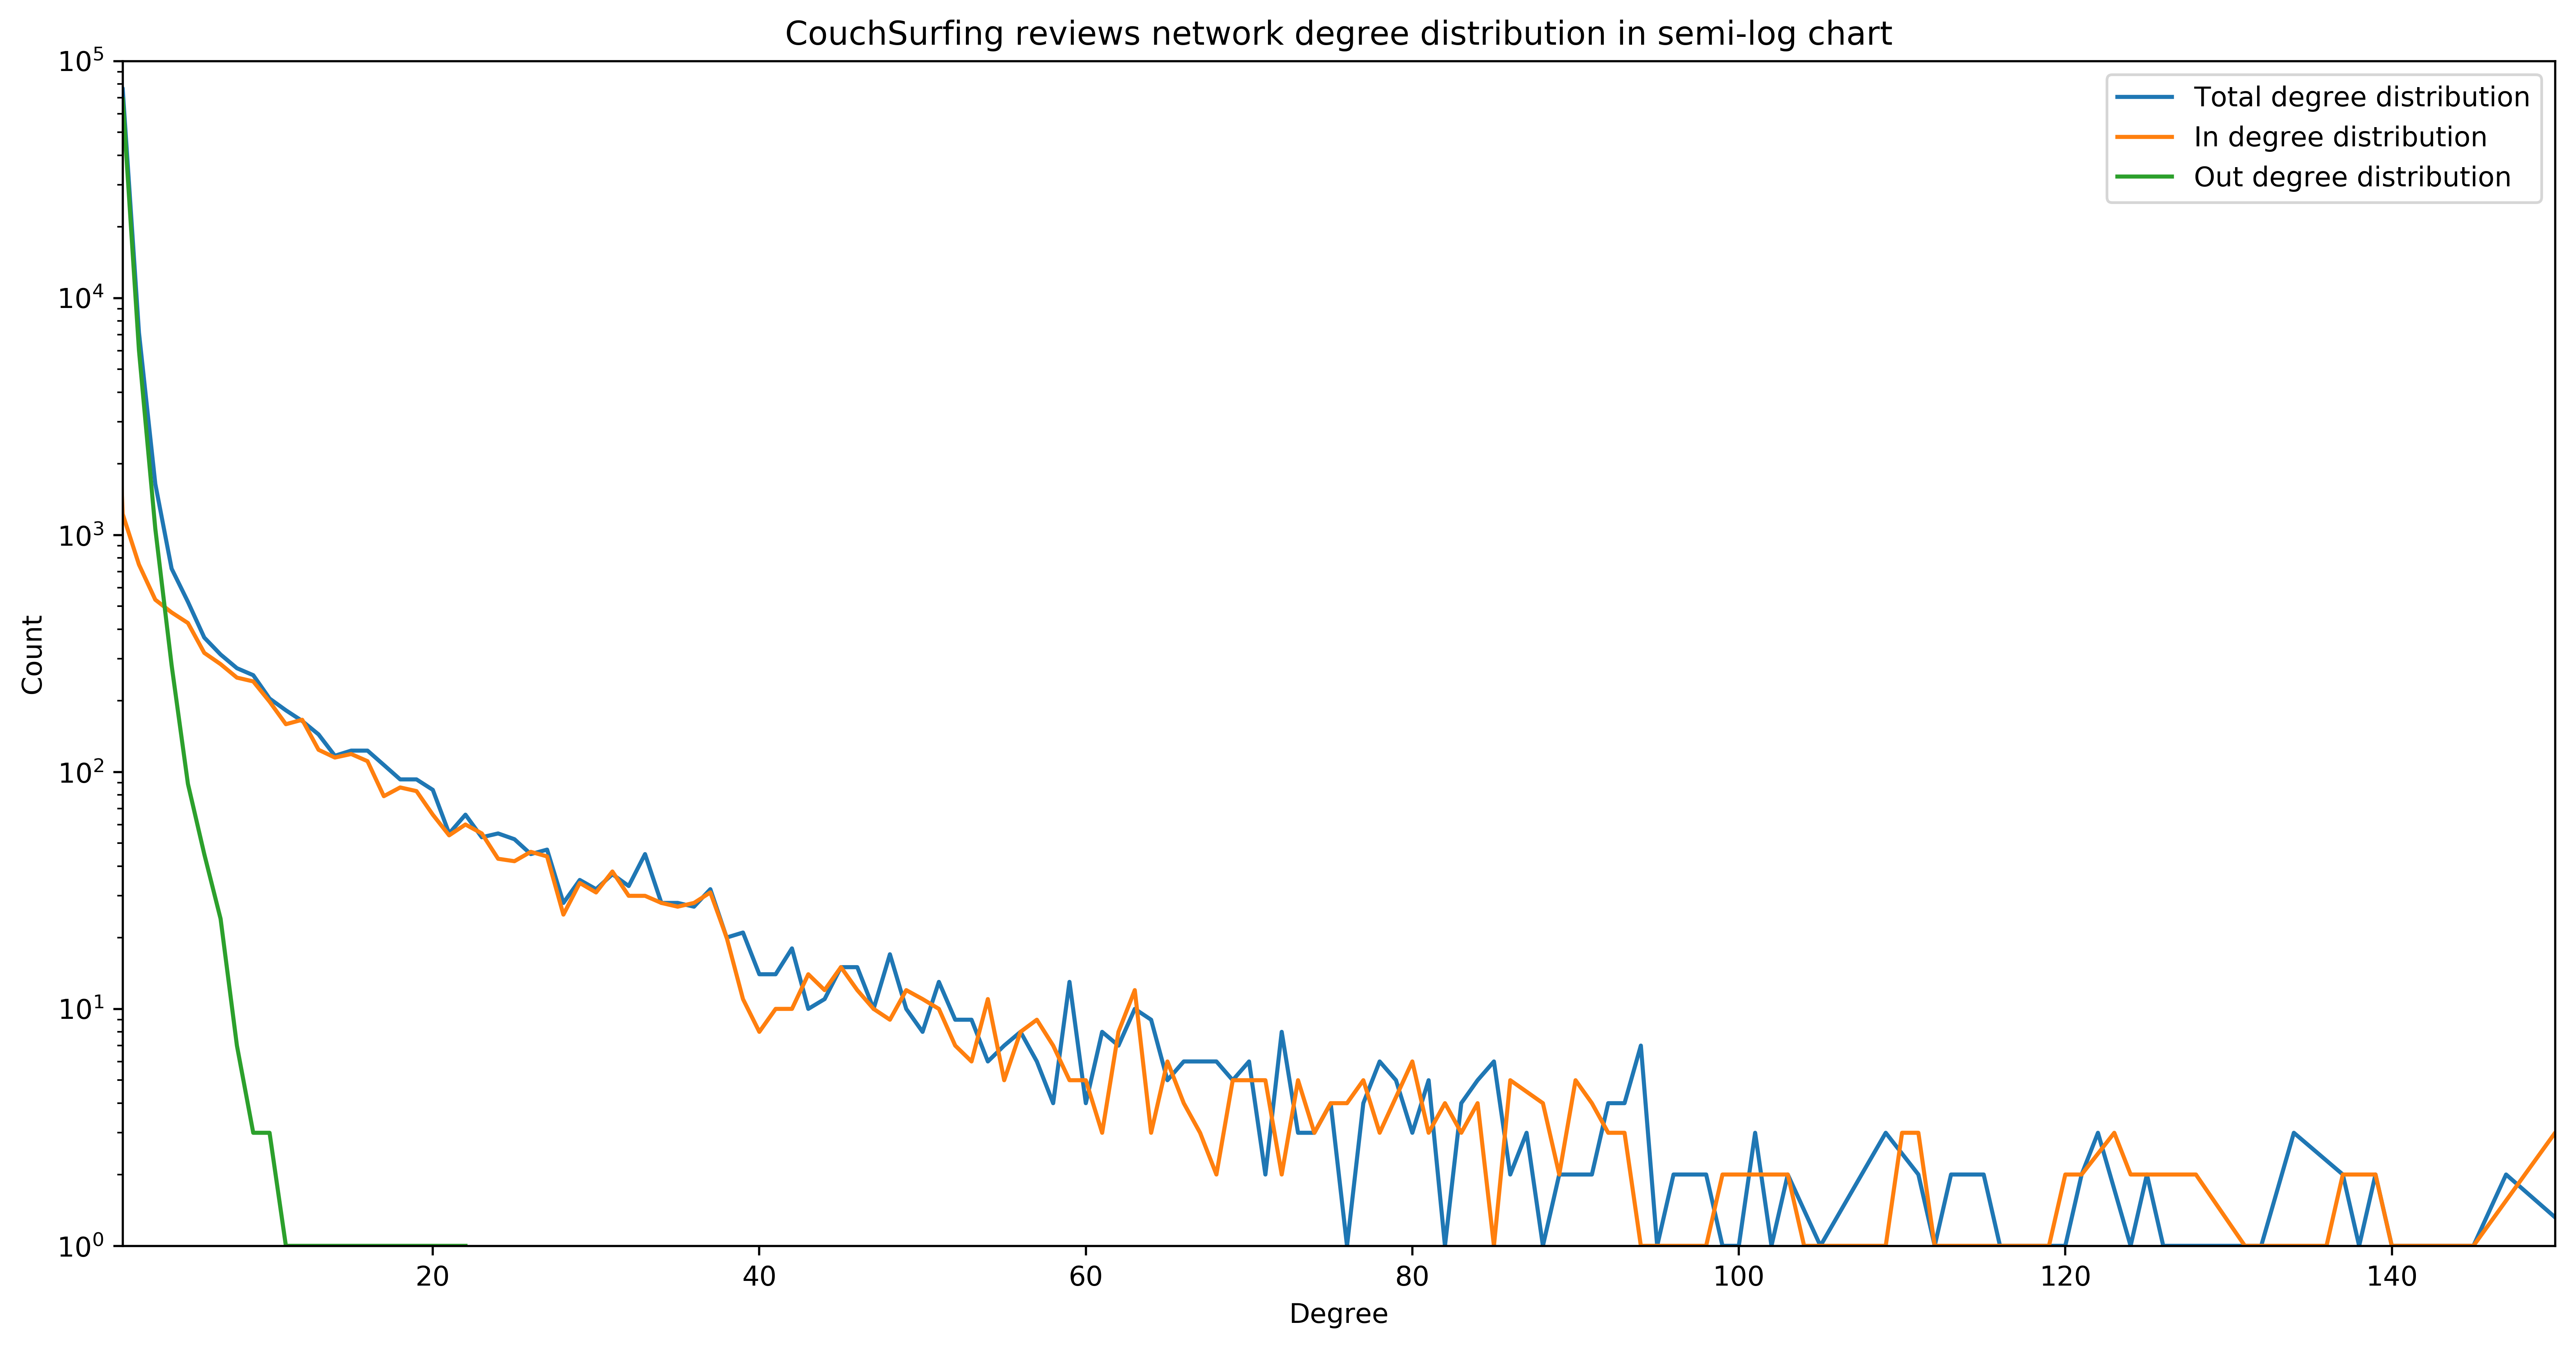

In [117]:
#4. Comparizon on semilog chart

plt.figure(figsize=(16, 8), dpi= 500)
#plt.bar(deg, cnt, width=0.80, color='b')
plt.semilogy(deg,cnt, label='Total degree distribution')
plt.semilogy(in_deg,in_cnt, label='In degree distribution')
plt.semilogy(out_deg,out_cnt, label='Out degree distribution')
plt.legend()
#fig= facecolor='w', edgecolor='w')
out_axes = plt.gca()
out_axes.set_xlim([1,150])
out_axes.set_ylim([1,100000])
plt.title("CouchSurfing reviews network degree distribution in semi-log chart")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.savefig('degree_dist_semi_log.png', dpi=500, transparent=True)
plt.show()

Because of high variety of degree distribution it's has been presented with semi-log scale.

In [118]:
# calculate nodes by cities
nodes_by_cities = dict()

nodes_by_cities['outside'] = ([],[])
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        if node[1]['city'] not in nodes_by_cities:
            nodes_by_cities[node[1]['city']] = ([],[])
        tup = nodes_by_cities[node[1]['city']]
        tup[0].append(G_withSentValue.in_degree(node[0]))
        tup[1].append(G_withSentValue.out_degree(node[0])) 
    else:
        tup = nodes_by_cities['outside']
        tup[0].append(G_withSentValue.in_degree(node[0]))
        tup[1].append(G_withSentValue.out_degree(node[0]))

#### 4.1.2 Nodes' degree (in and out) comparison:

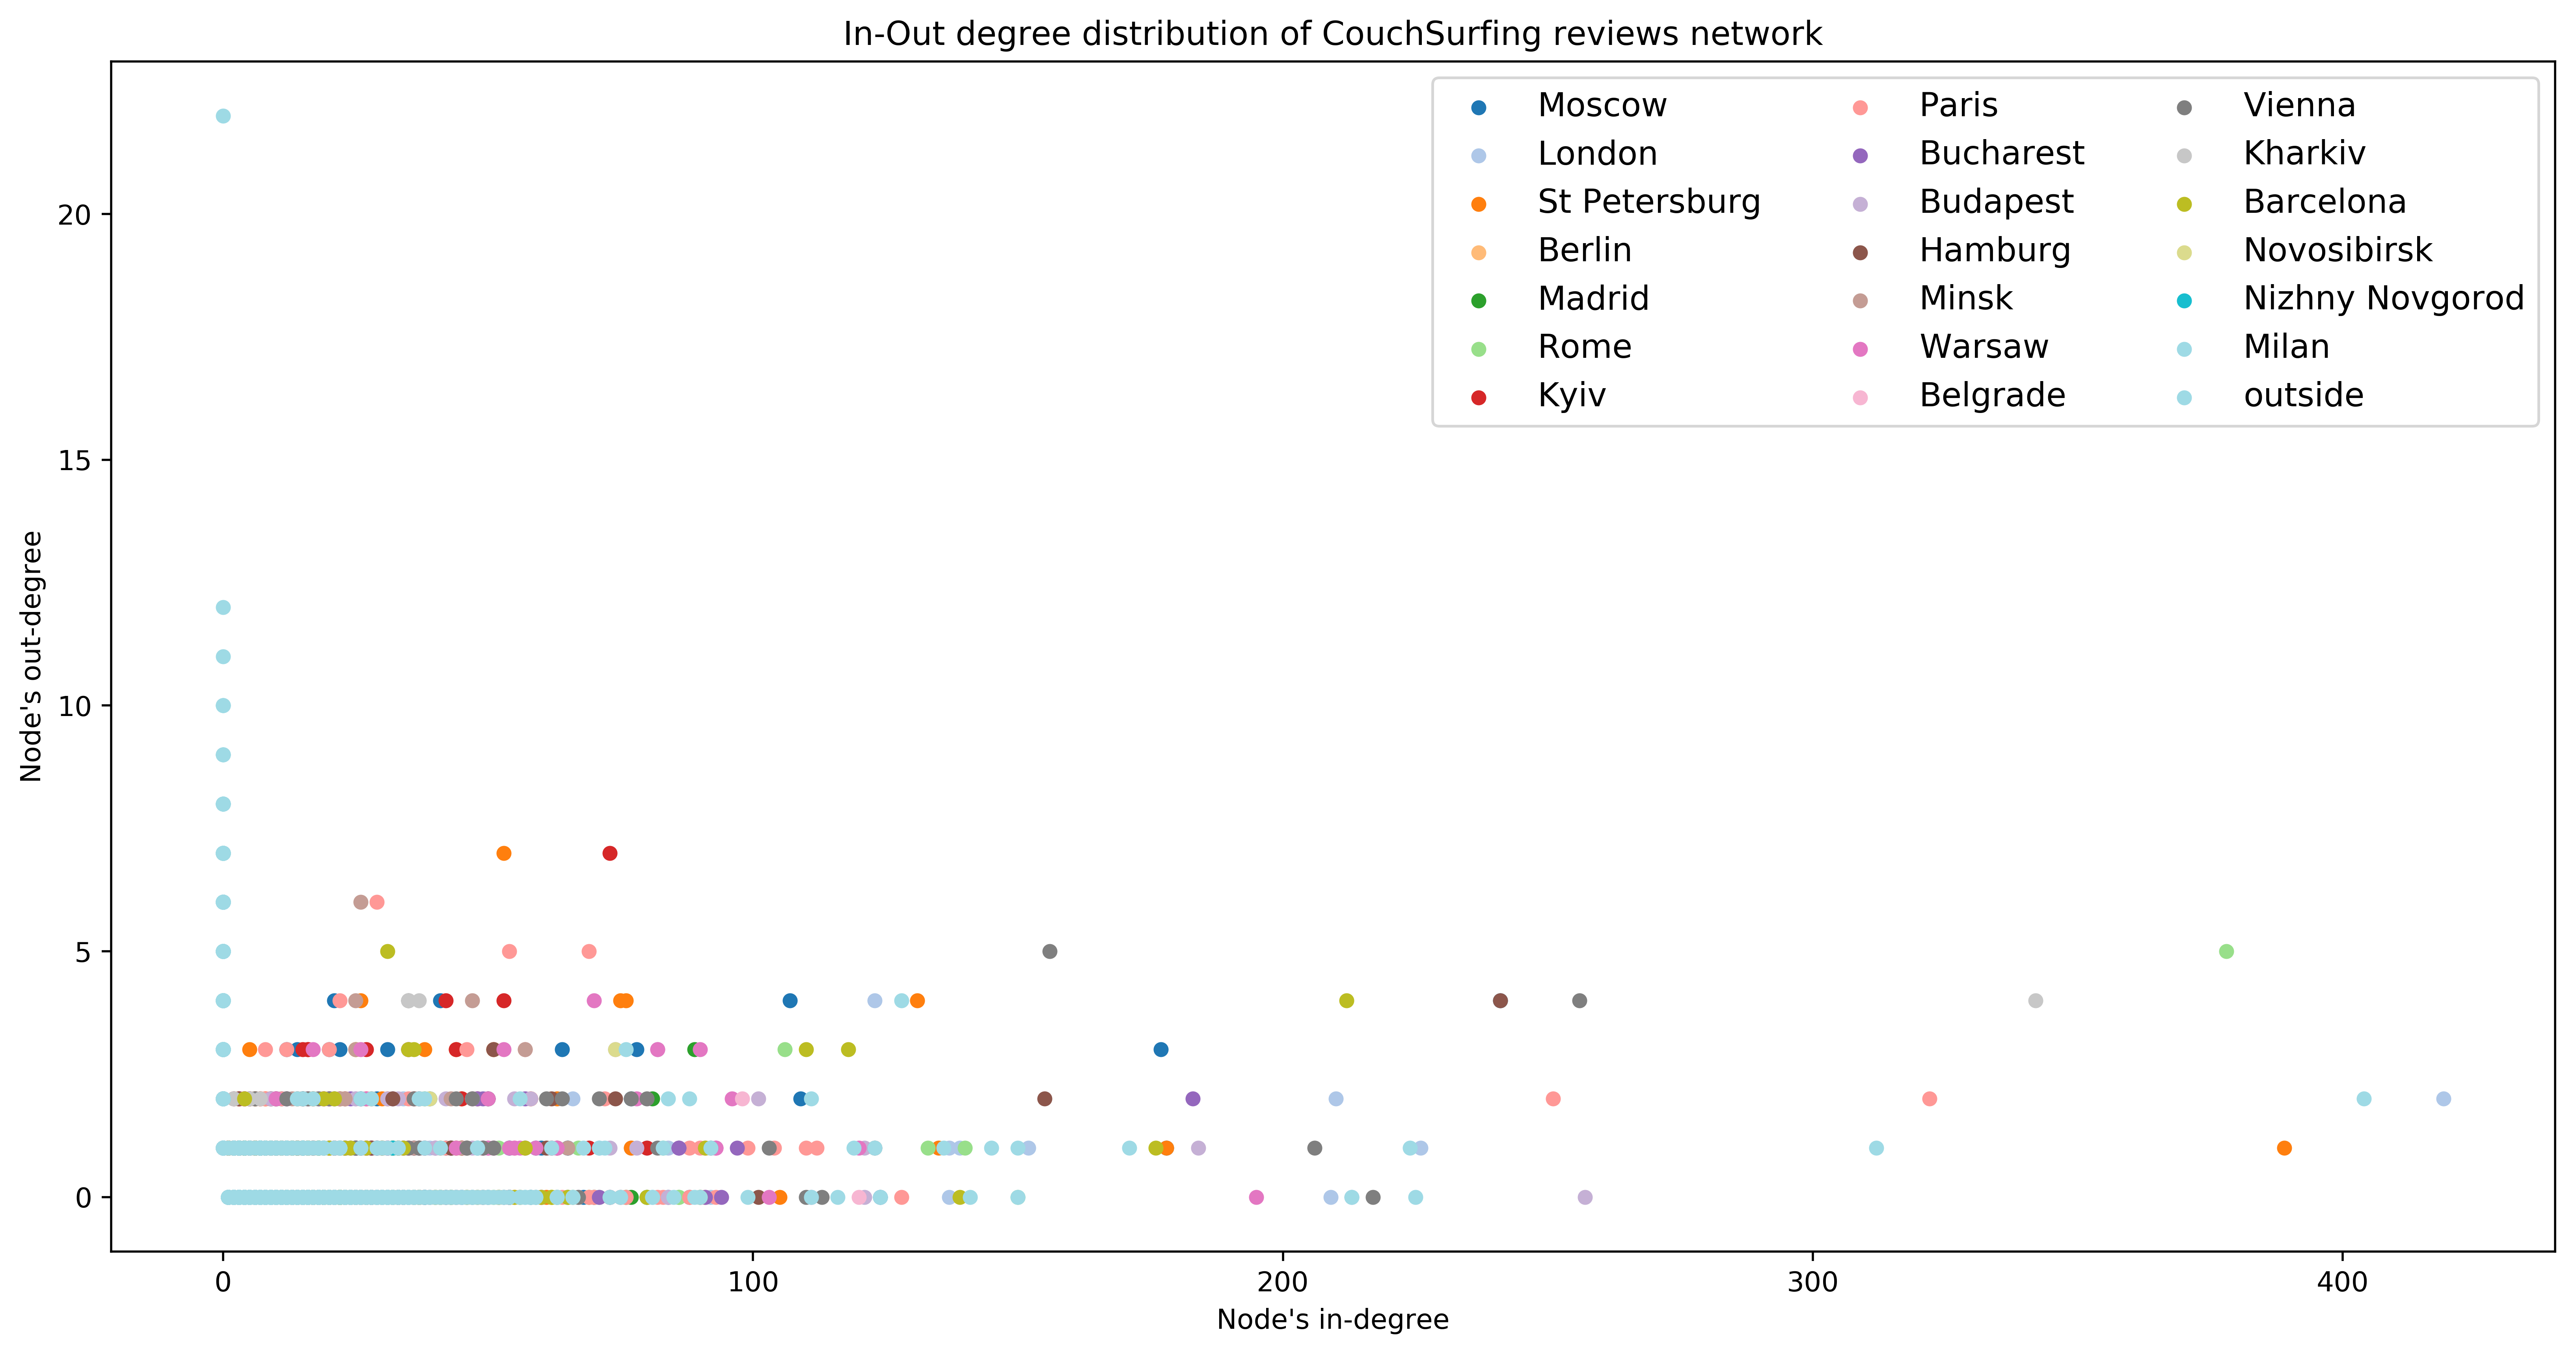

In [119]:
# scatter plot of in across out degree.
in_degree_values = []
out_degree_values = []
city_values = []

for node in G_withSentValue.nodes():
    in_degree_values.append(G_withSentValue.in_degree(node))
    out_degree_values.append(G_withSentValue.out_degree(node))
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        city_values.append(node[1]['city'] ) 
    else:
        city_values.append('outside')

plt.figure(figsize=(16, 8), dpi= 500)

scatter_list = []
for idx, city in enumerate(legend_city,start=0):
    scatter_list.append(plt.scatter(nodes_by_cities[city][0],nodes_by_cities[city][1], c=legend_col[idx] ,s=20))   

plt.legend(tuple(scatter_list),
           tuple(legend_city),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)

    
#plt.bar(deg, cnt, width=0.80, color='b')
#scatter, = plt.scatter(in_degree_values,out_degree_values, label='In-Out degree distribution', c=[city_to_color_dict[j] for j in city_values])
#plt.legend(tuple(legend_city),tuple([city_to_color_dict[j] for j in legend_city]))
plt.title("In-Out degree distribution of CouchSurfing reviews network")
plt.ylabel("Node's out-degree")
plt.xlabel("Node's in-degree")
plt.savefig('In-Out degree distribution of CouchSurfing reviews network.png' , dpi = 500, transparent=True)
plt.show()

From what city the most times rated host come from (in terms of number of received rates)?

In 10 % of hosts with the biggest number of reviews there is the most people from : Milan (16), Paris(14), London(13)

Discussion:
How users are acting?

From the graph we can notice disproportion between maximum value of in and out degree. It can be explain becaus of small proportionally small quantity of hosts that data was extracted for (about 10000). After addidion of the reviews our network grows to and in the edn it has about 83000 nodes. We can't conclude any asumptions from that data. 

In [42]:
#tool to pick appropriate treshold:
h = 0
for s in in_degree_sequence:
    if s>83:
        h=h+1
h

115

In [43]:
#checking how many of nodes of the fighest degree are afrom what cities

g = dict()
treshold = 83

for city, values in nodes_by_cities.items():
    g[city] = 0
    for h in values[0]:
        if h > treshold:
            b = g[city]
            g[city] = b + 1
            
g

{'Barcelona': 7,
 'Belgrade': 2,
 'Berlin': 0,
 'Bucharest': 6,
 'Budapest': 7,
 'Hamburg': 3,
 'Kharkiv': 1,
 'Kyiv': 0,
 'London': 13,
 'Madrid': 1,
 'Milan': 13,
 'Minsk': 0,
 'Moscow': 9,
 'Nizhny Novgorod': 0,
 'Novosibirsk': 0,
 'Paris': 12,
 'Rome': 7,
 'St Petersburg': 5,
 'Vienna': 9,
 'Warsaw': 8,
 'outside': 12}

### 4.2. Power-laws and Friendship Paradox:

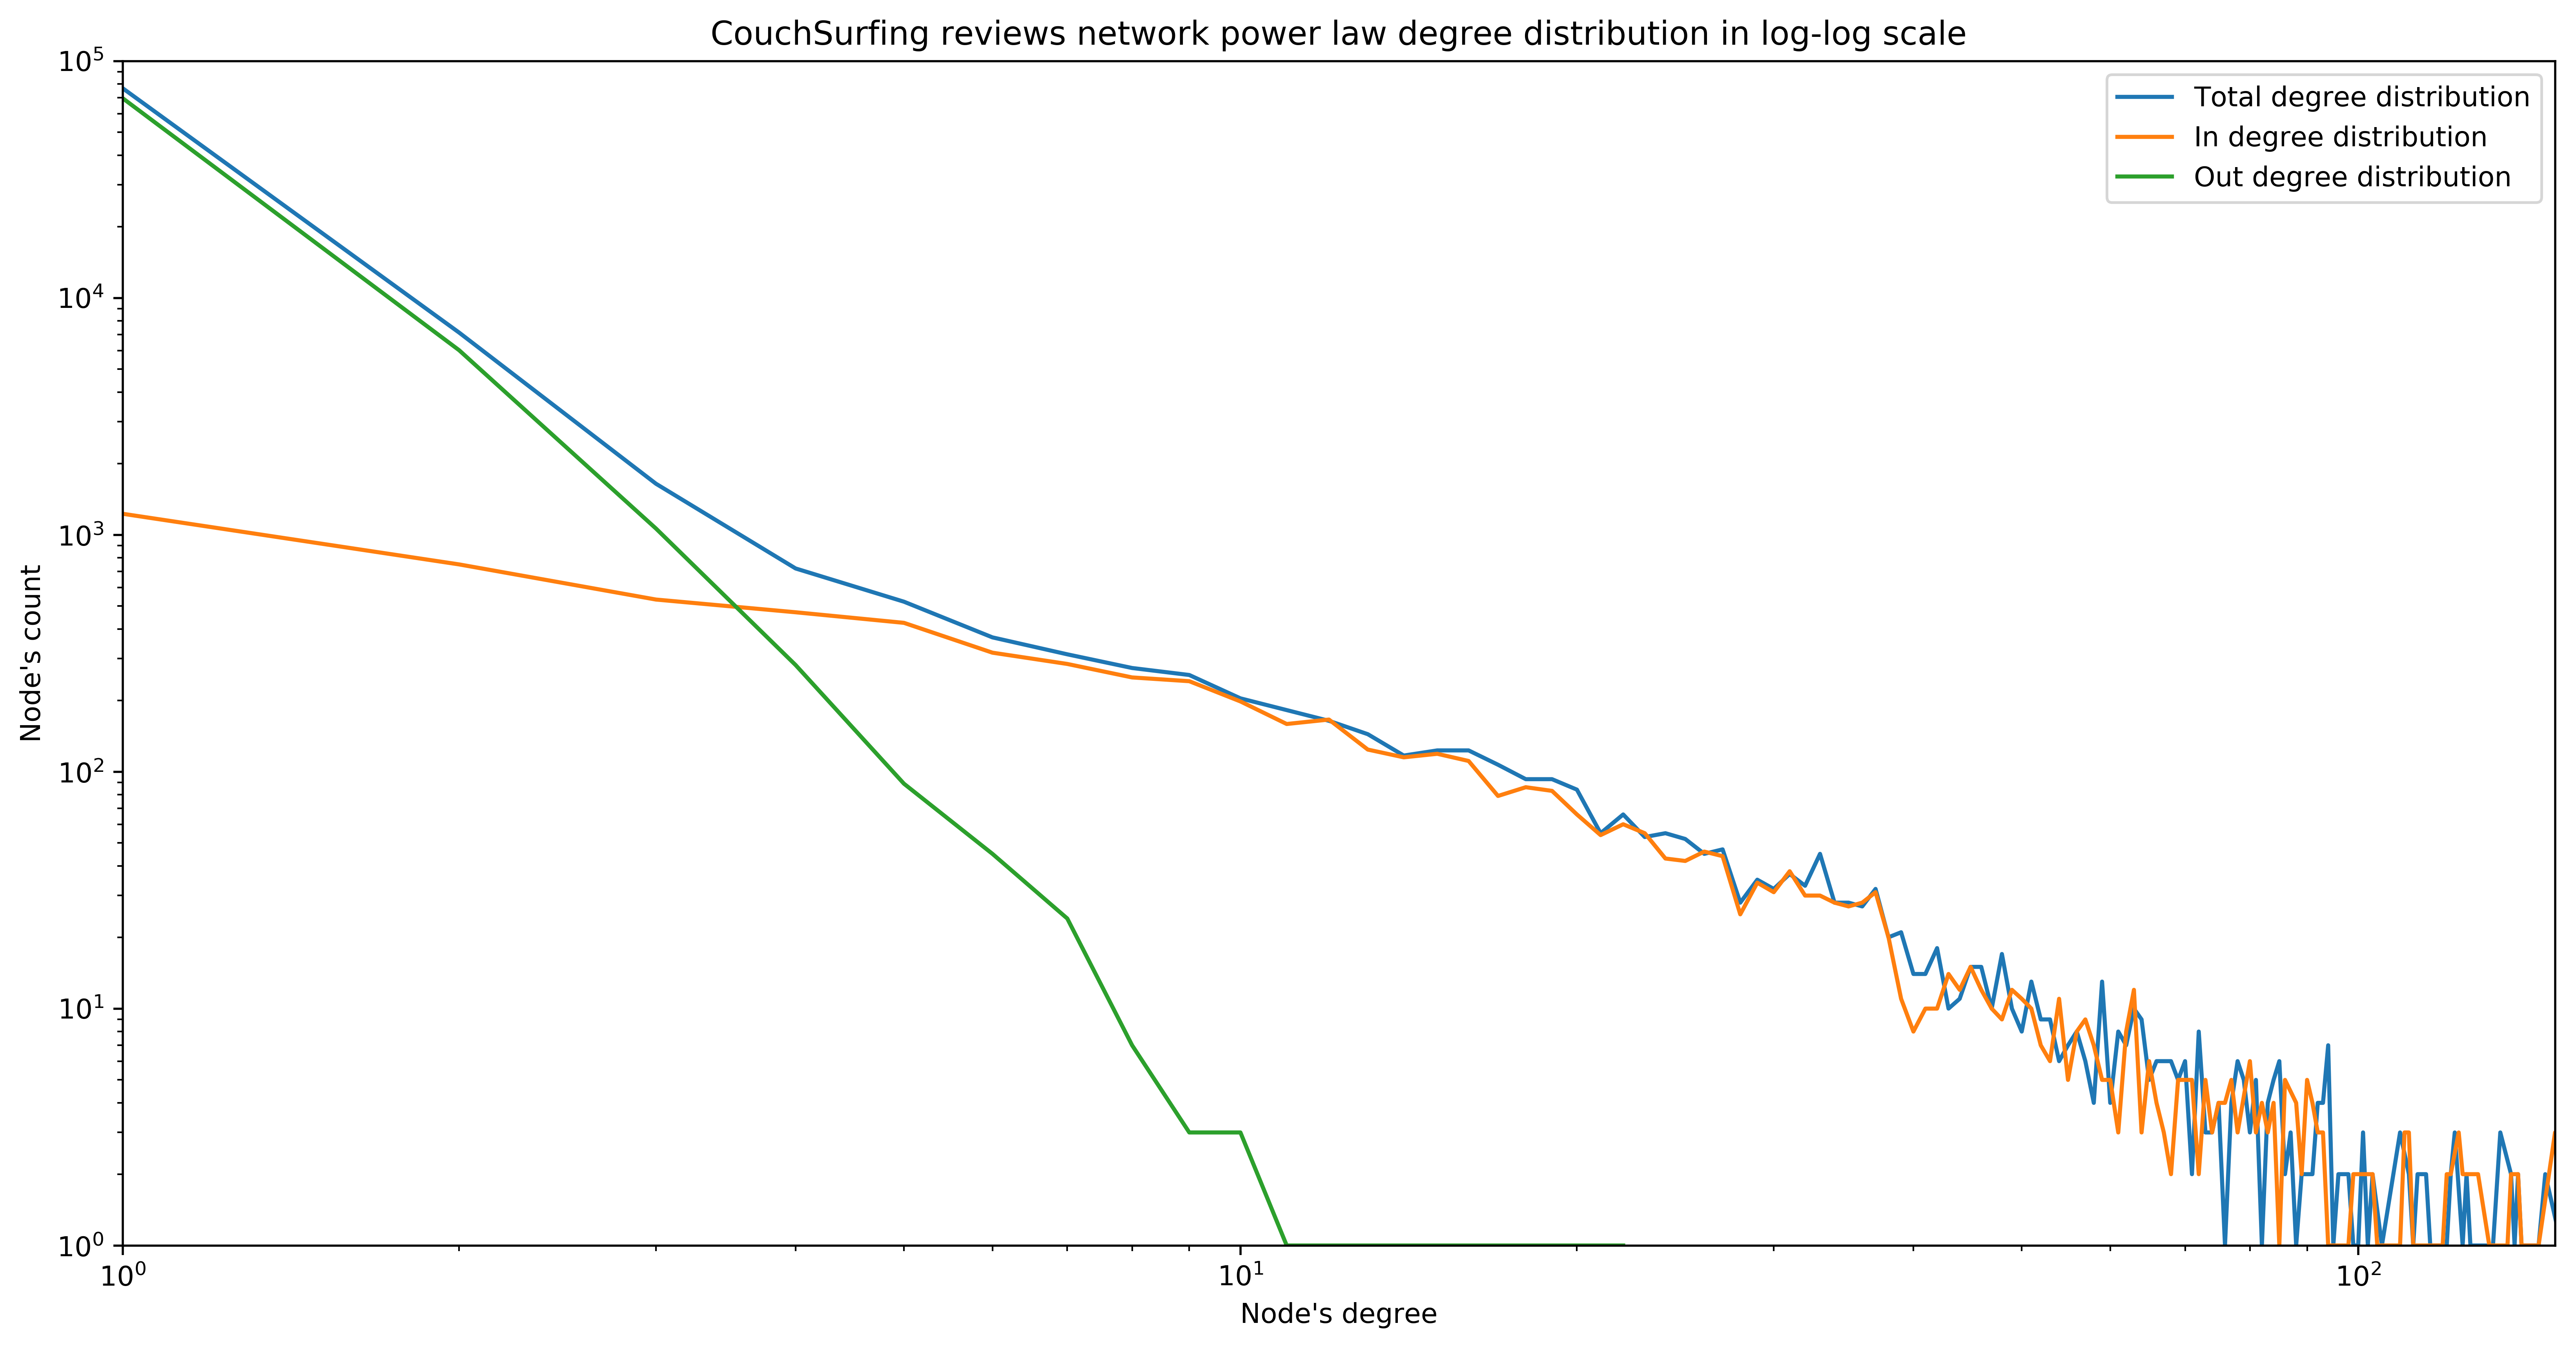

In [120]:
#5.Comparizon on loglog chart
plt.figure(figsize=(16, 8), dpi= 500)
#plt.bar(deg, cnt, width=0.80, color='b')
plt.loglog(deg,cnt, label='Total degree distribution')
plt.loglog(in_deg,in_cnt, label='In degree distribution')
plt.loglog(out_deg,out_cnt, label='Out degree distribution')
plt.legend()
#fig= facecolor='w', edgecolor='w')
out_axes = plt.gca()
out_axes.set_xlim([1,150])
out_axes.set_ylim([1,100000])
plt.title("CouchSurfing reviews network power law degree distribution in log-log scale")
plt.ylabel("Node's count")
plt.xlabel("Node's degree")
#ax.set_xticks([d + 0.4 for d in deg])
#ax.set_xticklabels(deg)
plt.savefig('CouchSurfing reviews network power law degree distribution.png' , dpi = 500, transparent=True)
plt.show()

What kind of network is it?

In the chart we can see that the degree distribution of CouchSurfing reviews network. It is a clear that this network is not random but scale-free network as it does not follow binominal but power law degree distribution. 

Which type of users are getting more reviews? Hosts or surfers? 

Moreover, we can notice that out and in degree distribution cross at some point. There is more surfers with low degree and more hosts with high degree distribution. It can be explained by fact that surfers ( out degree ) try that service sporadically but when they become hosts ( in degree ) then they start to receive reviews more often.

### 4.3\. Centrality

4.3.1. Betweenness Centrality:

In [121]:
# for visualization purposes:
def getColorfromCmap(val): 
    cmap = cm.get_cmap('tab20') 
    return cmap(val)

legend_city=[city['name'] for idx,city in cities.iterrows()]
legend_city.append('outside')
legend_col=[getColorfromCmap(idx/(len(legend_city)-1)) for idx,x in enumerate(legend_city)]



  Number of nodes with betweenness centrality equal to 0:  82727 



  Number of nodes with betweenness centrality bigger than 0:  325 




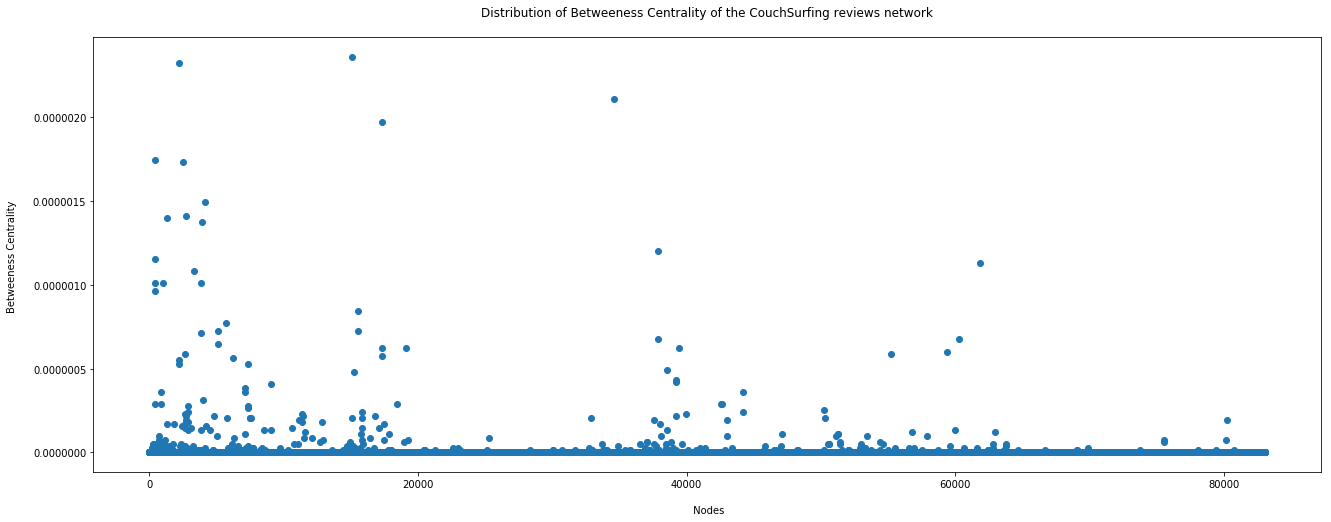

In [129]:
#plotting betweenness centrality of network

betweenness_centrality = nx.betweenness_centrality(G_withSentValue, k=1000)

no_bc_0 = list(betweenness_centrality.values()).count(0.0)
print("\n  Number of nodes with betweenness centrality equal to 0: ",no_bc_0,"\n\n")
print("\n  Number of nodes with betweenness centrality bigger than 0: ",len(list(betweenness_centrality.values()))-no_bc_0 ,"\n\n")

plt.figure(figsize = (22,8))
plt.plot(list(betweenness_centrality.values()),'o') 
plt.title("Distribution of Betweeness Centrality of the CouchSurfing reviews network\n")
plt.xlabel("\n Nodes")
plt.ylabel("Betweeness Centrality \n")
plt.show()

In [ ]:
#are you sure unidirected!!!!

#plotting betweenness centrality of network but unidirected

#betweenness_centrality = nx.betweenness_centrality(G_withSentValue, k=1000)
betweenness_centrality_unidirected = nx.betweenness_centrality(G_withSentValue.to_undirected(), k=1000)

no_bc_u_0 = list(betweenness_centrality_unidirected.values()).count(0.0)
print("\n  Number of nodes with betweenness centrality equal to 0: ",no_bc_u_0,"\n\n")
print("\n  Number of nodes with betweenness centrality bigger than 0: ",len(list(betweenness_centrality_unidirected.values()))-no_bc_u_0 ,"\n\n")

plt.figure(figsize = (22,8))
plt.plot(list(betweenness_centrality_unidirected.values()),'o') 
plt.title("Distribution of Betweeness Centrality of the CouchSurfing reviews network\n")
plt.xlabel("\n Nodes")
plt.ylabel("Betweeness Centrality \n")
plt.show()

In [131]:
# calculation of the distribution of centrality by different cities:

node_to_city_dict = dict()
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        if node[0] not in node_to_city_dict:
            node_to_city_dict[node[0]] = node[1]['city']
    else:
        node_to_city_dict[node[0]] = 'outside'
        
beetweennes_centrality_nodes_by_city = dict()
for key, value in betweenness_centrality.items():
    if value > 0.0 :
        city = node_to_city_dict[key]
        if city not in beetweennes_centrality_nodes_by_city:
            beetweennes_centrality_nodes_by_city[city] = []
        beetweennes_centrality_nodes_by_city[city].append(tuple([key, value]))   

for key1, value in beetweennes_centrality_nodes_by_city.items():
    value.sort(key=lambda x: x[1], reverse=True)

In [132]:
for key, value in beetweennes_centrality_nodes_by_city.items():
    print(key, ' : ', value[0][1] )
    
beetweennes_centrality_nodes_by_city['Moscow']

Moscow  :  1.7459572054805607e-06
Milan  :  4.0939686197475217e-07
Minsk  :  2.323929245915505e-06
Kharkiv  :  2.360052498442689e-06
Paris  :  9.632867340582404e-07
Kyiv  :  1.974737804819393e-06
London  :  2.287805993388321e-07
Madrid  :  2.0469843098737609e-07
St Petersburg  :  1.4930944377902726e-06
Warsaw  :  6.743007138407683e-07
Novosibirsk  :  1.3967657643844486e-06
Vienna  :  1.1318619125184325e-06
Rome  :  1.7339161213048327e-06
Belgrade  :  1.3245192593300806e-07
Barcelona  :  1.2041084175728005e-06
Bucharest  :  3.8531469362329616e-07
Budapest  :  8.428758923009604e-07
outside  :  8.428758923009604e-08
Hamburg  :  2.107189730752401e-06
Nizhny Novgorod  :  2.889860202174721e-07


[(2004013575, 1.7459572054805607e-06),
 (822436, 1.4088068485601766e-06),
 (2002969804, 1.0114510707611524e-06),
 (45281, 1.0114510707611524e-06),
 (2000347000, 1.0114510707611524e-06),
 (2791380, 6.502185454893123e-07),
 (2596672, 5.900131246106722e-07),
 (880760, 5.538898720834882e-07),
 (1007560704, 5.298077037320322e-07),
 (3644180, 3.6123252527184015e-07),
 (1000788203, 3.1306818856892813e-07),
 (1000153053, 2.769449360417441e-07),
 (2005187306, 2.769449360417441e-07),
 (1001885315, 2.167395151631041e-07),
 (1002670150, 2.0469843098737609e-07),
 (2002955433, 1.6857517846019207e-07),
 (2284225, 1.5653409428446407e-07),
 (2004431404, 9.632867340582404e-08),
 (370083, 8.428758923009604e-08),
 (4837184, 7.224650505436803e-08),
 (1219678, 4.816433670291202e-08),
 (2005626227, 4.816433670291202e-08),
 (2001626146, 3.6123252527184015e-08),
 (1000596094, 3.6123252527184015e-08),
 (3734254, 3.6123252527184015e-08),
 (2007718276, 3.6123252527184015e-08),
 (4935233, 2.408216835145601e-08),
 

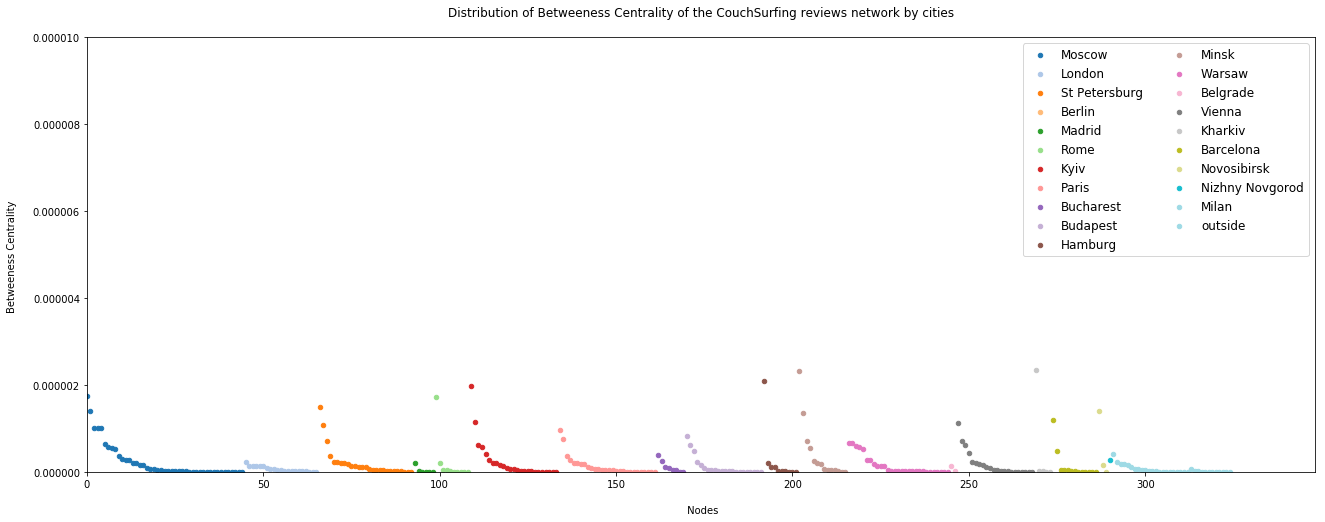

In [133]:
plt.figure(figsize = (22,8))
 
    
scatter_list = []
h = 0
for idx, city in enumerate(legend_city,start=0):
    if city not in beetweennes_centrality_nodes_by_city:
            beetweennes_centrality_nodes_by_city[city] = []
    bc_values = [ el[1] for el in beetweennes_centrality_nodes_by_city[city]]
    scatter_list.append(plt.scatter( range(h, h + len(bc_values)), bc_values , c=legend_col[idx], s=20 )) 
    h = h + len(bc_values)
    
plt.legend(tuple(scatter_list),
           tuple(legend_city),
           scatterpoints=1,
           loc='upper right',
           ncol=2,
           fontsize=12)

out_axes = plt.gca()
out_axes.set_xlim([0,348])
out_axes.set_ylim([0,0.00001])

plt.title("Distribution of Betweeness Centrality of the CouchSurfing reviews network by cities\n")
plt.xlabel("\n Nodes")
plt.ylabel("Betweeness Centrality \n")
plt.savefig('hostes_netweenness_centrality_mesures.png' , dpi = 500, transparent=True)
plt.show()

In [134]:
# get relevnt nodes by city:
relevant_nodes = []
for node, bc in betweenness_centrality.items():
    if bc > 0.0:
        relevant_nodes.append((node, bc ))
        
G_bc = nx.Graph(G_withSentValue.subgraph([x[0] for x in relevant_nodes]))
        
color_map_nodes = []
for node in G_bc.nodes(data=True):
    if node[1]:
        color_map_nodes.append(citi_to_color_dict[node[1]['city']])
    else:
        color_map_nodes.append(citi_to_color_dict['outside'])
        
relevant_edges = []

for u,v,no in G_withSentValue.edges:
    if betweenness_centrality[u] > 0.00 and betweenness_centrality[v] > 0.00:
        relevant_edges.append((u,v))
print(len(relevant_edges))
    
G_bc.add_edges_from( relevant_edges )

330


In [135]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=0.5,

                          # Performance
                          jitterTolerance=0.2,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.5,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=6.0,
                          strongGravityMode=False,
                          gravity=0,

                          # Log
                          verbose=False)


positions_centrality = forceatlas2.forceatlas2_networkx_layout(G_bc, pos=None, iterations=10)

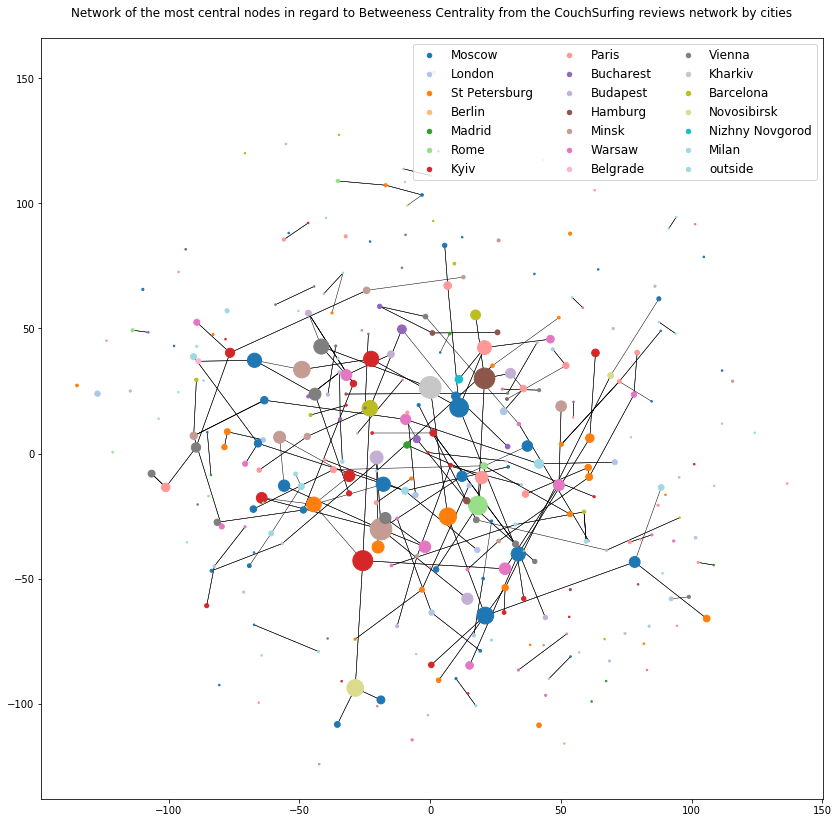

In [136]:
#create edges that connect relevant nodes concercing betweenness centrality

plt.figure(1,figsize=(14,14))

nx.draw_networkx_nodes(G_bc, pos = positions_centrality,  node_color = color_map_nodes,node_size=[x[1]* 200000000 for x in relevant_nodes], with_labels=True)
nx.draw_networkx_edges(G_bc,positions_centrality,edgelist = relevant_edges, edge_color='black', width = 0.5)

plt.legend(tuple(scatter_list),
           tuple(legend_city),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)

plt.title("Network of the most central nodes in regard to Betweeness Centrality from the CouchSurfing reviews network by cities\n")
plt.savefig('Network_of_the_most_central_nodes_in_regard_to_Betweeness_Centrality.png', transparent = True, dpi = 500)
plt.show()

Who are the most active users?

We may notice that the most central users are mostly people from Eastern European cities like Moscow, St Petersburg, Kyiv, Warsaw, Kharkiv and Minsk. But we can notice some nodes from Budapest or Barcelona The most central node is from Minsk.
It is like that because people from Eastern Europe beside being a host they are also more often a surfers. Thanks to that they become a node in the graph that is used more times while calculation paths.

#### 4.3.2 Eigenvector Centrality

In [ ]:
eigenvector_centrality = nx.betweenness_centrality(G_withSentValue, k=1000)

no_bc_0 = list(betweenness_centrality.values()).count(0.0)
print("\n  Number of nodes with betweenness centrality equal to 0: ",no_bc_0,"\n\n")
print("\n  Number of nodes with betweenness centrality bigger than 0: ",len(list(betweenness_centrality.values()))-no_bc_0 ,"\n\n")

plt.figure(figsize = (22,8))
plt.plot(list(betweenness_centrality.values()),'o') 
plt.title("Distribution of Betweeness Centrality of the CouchSurfing reviews network\n")
plt.xlabel("\n Nodes")
plt.ylabel("Betweeness Centrality \n")
plt.show()

#### 4.3.3 Degree Centrality

### 4.4\. Assortativity: